In [151]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt


In [152]:
import numpy as np
import pandas as pd
import datetime as dt
# https://www.geeksforgeeks.org/how-to-add-and-subtract-days-using-datetime-in-python/
from dateutil.relativedelta import relativedelta
from datetime import datetime

# Reflect Tables into SQLAlchemy ORM

In [153]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, distinct

In [154]:
# Create engine using the `hawaii.sqlite` database file
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [155]:
# Declare a Base using `automap_base()`
Base = automap_base()

# Use the Base class to reflect the database tables
Base.prepare(autoload_with=engine)

In [156]:
# Print all of the classes mapped to the Base
Base.classes.keys()

['measurement', 'station']

In [157]:
# Assign the measurement class to a variable called `Measurement` and
# assign the station class to a variable called `Station`
Measurement = Base.classes.measurement
Station = Base.classes.station

In [158]:
# Create a session
session = Session(engine)

# Exploratory Precipitation Analysis

In [159]:
# Find the most recent date in the data set.
max_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
max_date_str = max_date[0]
max_date_str

'2017-08-23'

In [160]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.
# Starting from the most recent data point in the database.
max_date_fmt = datetime.strptime(max_date_str, '%Y-%m-%d')

# Calculate the date one year from the last date in data set.
date_12m_prior = max_date_fmt - relativedelta(years=1, days=1)

# Perform a query to retrieve the data and precipitation scores
precip = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date > date_12m_prior)

df = pd.read_sql(precip.statement, session.bind)
df

,date,prcp
0,2016-08-23,0.0
1,2016-08-24,2.0
2,2016-08-25,2.0
3,2016-08-26,0.0
4,2016-08-27,0.0
...,...,...
2225,2017-08-19,2.3
2226,2017-08-20,NaN
2227,2017-08-21,14.2
2228,2017-08-22,12.7


In [161]:
df_dropna = df.dropna()
df_clean = df_dropna.loc[df_dropna['prcp'] != 0]

# sort dataframe
df_clean2 = df_clean.sort_values(by=['date'])
df_clean3 = df_clean2.reset_index()
df_clean3

,index,date,prcp
0,1529,2016-08-23,45.5
1,1881,2016-08-23,17.8
2,1192,2016-08-23,0.5
3,704,2016-08-23,1.3
4,361,2016-08-23,3.8
...,...,...,...
1142,1007,2017-08-21,0.5
1143,2227,2017-08-21,14.2
1144,2228,2017-08-22,12.7
1145,1528,2017-08-23,2.0


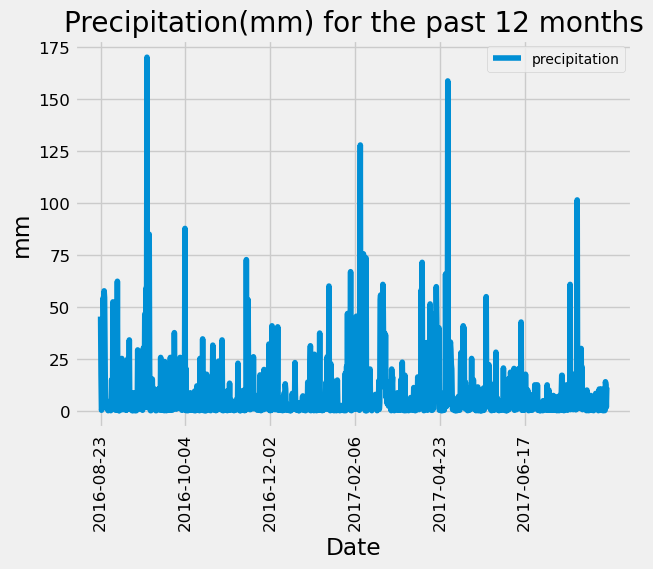

In [162]:
# Use Pandas Plotting with Matplotlib to plot the data
x = df_clean3['date'].tolist()
x = np.asarray(x, dtype='datetime64[D]')

y = df_clean3['prcp'].tolist()

ax = df_clean3.prcp.plot(title='Precipitation(mm) for the past 12 months', 
                     fontsize=12,
                     xlabel='Date',
                     ylabel='mm',
                     legend=True,
                     rot=90                   
                     )

# force x date values to be datetime datatype https://stackoverflow.com/questions/26358200/xticks-by-pandas-plot-rename-with-the-string
ax.set_xticks(ticks=df_clean3.index, labels=df_clean3.date)

plt.locator_params(axis='x', nbins=6)
ax.legend(['precipitation'], fontsize=10)

# Save figure 
plt.savefig('Images/precip_past_12mth.png', bbox_inches="tight")

plt.show()

In [163]:
# Use Pandas to calculate the summary statistics for the precipitation data
df['prcp'].describe()

count    2021.000000
mean        4.505888
std        11.713487
min         0.000000
25%         0.000000
50%         0.500000
75%         3.300000
max       170.200000
Name: prcp, dtype: float64

# Exploratory Station Analysis

In [164]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(distinct(Station.station)))
total_stations[0]

(9,)

In [165]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
station_obs_count = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
station_obs_count

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [166]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
# Get max date
max_date_temp = session.query(Measurement.date).filter(Measurement.station=='USC00519281').order_by(Measurement.date.desc()).first()
max_date_temp_str = max_date_temp[0]
max_date_temp_str
max_date_temp_fmt = datetime.strptime(max_date_temp_str, '%Y-%m-%d')

# Calculate the date one year from the last date in data set.
date_12m_prior_temp = max_date_temp_fmt - relativedelta(years=1,days=1)

In [167]:
# Get stationd ID with most activity
max_obs_station_id = station_obs_count[0][0]
print(max_obs_station_id)

# Get min, max, and average temperatures for the most active station
connection = engine.connect()
result = connection.execute(f"SELECT MIN(tobs), MAX(tobs), avg(tobs) FROM measurement where station = '{max_obs_station_id}'")

for row in result:
    print(row)

USC00519281
(12.2, 29.4, 22.03582251082252)


In [168]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_query = session.query(Measurement.tobs).filter(Measurement.date > date_12m_prior) \
    .filter(Measurement.station==max_obs_station_id)

df_temp = pd.read_sql(temp_query.statement, session.bind)

df_temp

,tobs
0,25.0
1,25.0
2,26.7
3,26.7
4,23.9
...,...
347,25.0
348,25.0
349,24.4
350,24.4


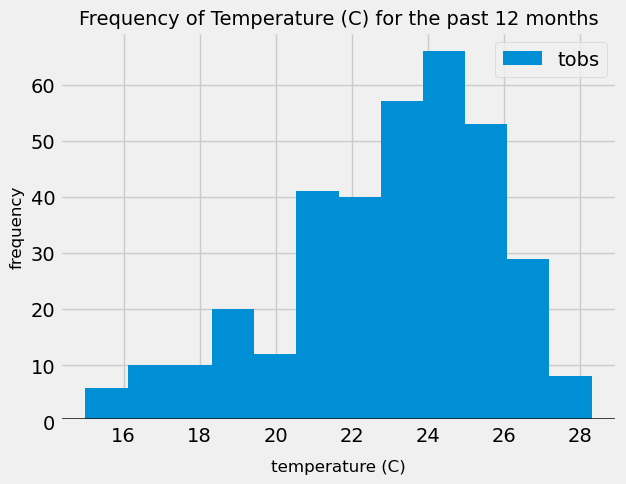

In [169]:
fig2, ax2 = plt.subplots()

# set x and y axes
x = df_temp['tobs'].tolist()

# Plot bar chart
ax2.hist(x, bins=12, label='tobs')
ax2.set_xlabel('temperature (C)',labelpad=10, fontsize=12)
ax2.set_ylabel('frequency', fontsize=12)
ax2.set_title('Frequency of Temperature (C) for the past 12 months', fontsize=14)


plt.axhline(0, color='black')
plt.legend()

plt.savefig('Images/freq_temp_recorded.png')

plt.show()

# Close Session

In [170]:
# Close Session
session.close()